# **DSBA 6165: AI & Deep Learning**

Professor: Rick Chakra

TA: Spencer Tilley

# Decision Tree Classifier Building in Scikit-learn

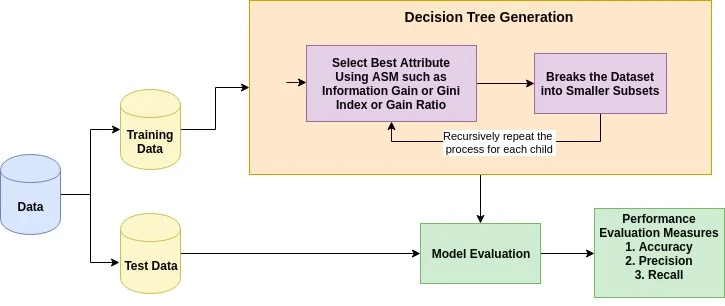

## Importing Required Libraries

Let's first load the required libraries.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets #Import scikit-learn dataset library
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import GridSearchCV # Import for hyperparameter tuning
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix

## Loading Data
Let's first load the required Pima Indian Diabetes dataset using pandas' read CSV function. This time the data is imported through URL instead of last week where it was downloaded on Canvas

In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# Read csv, using url as file
diabetes = pd.read_csv(url, header=None, names=col_names)
#Look at top rows to insure it worked
diabetes.head()


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Basic EDA and statistical analysis

Let's start of with doing some basic EDA. This should be done every time you are opening a new data set. The only real steps for this is to look at the info to get information on nulls and to look at describe to get statistical information.


In [3]:
# Print dataset info
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   label     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


The main things to note from this are
1. No Null values
2. All variables are numbers

Now let's move on to the statistics

In [4]:
# Dataset Statistics. We dont need include='all' as all of our variables are numbers!
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnant,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
bp,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skin,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
label,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


The question creeping out of this summary is:

*Can minimum value of below listed columns be zero (0)?*

On these columns, a value of zero does not make sense and thus indicates missing value.

Following columns or variables have an invalid zero value:

* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI

It is better to replace zeros with nan since after that counting them would be easier and zeros need to be replaced with suitable values. Since we are going to be heavily messing with the dataset let's make a copy so the original data isn't altered

In [5]:
# Create a deep copy of your dataset
diabetes_copy = diabetes.copy(deep=True)

# Replace the missing values
diabetes_copy[['glucose','bp','skin','insulin','bmi']] = diabetes_copy[['glucose','bp','skin','insulin','bmi']].replace(0,np.NaN)
# Check for missing values
print(diabetes_copy.isnull().sum())

pregnant      0
glucose       5
bp           35
skin        227
insulin     374
bmi          11
pedigree      0
age           0
label         0
dtype: int64


For the sake of time let's fill all of the new null values with the median for the variable.

**DON'T USE EASY FIXES LIKE THIS FOR PROJECT**

In [6]:
# Impute missing values with the median
diabetes_copy.fillna(diabetes_copy.median(), inplace=True)

## Feature Selection
Here, you need to divide given columns into two types of variables dependent (or target variable) and independent variable (or feature variables).

A capital X is used for the dependant variables while a lowercase y is used for the dependant. There is no reason for this other than conventional use in industry

In [7]:
 #split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
# Features
X = diabetes_copy[feature_cols]
# Target variable
y = diabetes_copy.label

## Splitting Data

To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

Let's split the dataset by using function train_test_split(). You need to pass 3 parameters features, target, and test_set size.

In [8]:
# Split dataset into training set and test set, declare random state for repeatability
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Building Decision Tree Model

Let's create a Decision Tree Model using Scikit-learn. Many of the sklearn algorithms are implemented using the same standard steps:

Step 1: Initiate the algorithm. Define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, the maximum depth, the minimum samples in a leaf etc. (check documentation for more information)

Step 2: Train the algorithm. Train the algorithm by fitting it to the X_train and y_train datasets.

Step 3: Evaluating the algorithm. Evaluate the predictive power of the algorithm by comparing the predicted target values to the true values. We can do this for the training and testing dataset.

In [9]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state=42)

# Train Decision Tree Classifer
dt = dt.fit(X_train,y_train)

# Predict the response for test dataset
y_pred=dt.predict(X_test)

## Evaluating Model
Let's estimate how accurately the classifier or model can predict diabetes.

Accuracy can be computed by comparing actual test set values and predicted values.

In [10]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7229437229437229


Well, you got a classification rate of 72.29%, considered as good accuracy. You can improve this accuracy by tuning the parameters in the Decision Tree Algorithm.

## Visualizing Decision Trees

You can use Scikit-learn's export_graphviz function for display the tree within a Jupyter notebook.

In [12]:
#Import some additional libraries
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

# Plot the decision tree
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.png')
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

What's your first reaction when seeing this? Probably something along the lines of "I can't read this!"

This is due to the tree being unpruned. This unpruned tree is unexplainable, overfits, and not easy to understand. In the next section, let's optimize it by pruning.

## Optimizing Decision Tree Performance.

In Scikit-learn, optimization of decision tree classifier is performed by only pre-pruning. Maximum depth of the tree can be used as a control variable for pre-pruning. In the following the example, you can plot a decision tree on the same data with max_depth=3. Here is a list of other pre-pruning parameters:

**criterion : optional (default=”gini”) or Choose attribute selection measure:** This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.


**max_depth : int or None, optional (default=None) or Maximum Depth of a Tree:** The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting.

In [13]:
# Create Decision Tree classifer object use a different name here. This allows for previous model to be called upon if were to need it
dt2 = DecisionTreeClassifier(criterion="entropy", max_depth=3,random_state = 1)

# Train Decision Tree Classifer
dt2 = dt2.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dt2.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7662337662337663


Well, the classification rate increased to 76.62%, which is better accuracy than the previous model.

In [ ]:
# Plot the decision tree
dot_data = StringIO()
export_graphviz(,
                out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.png')
Image(graph.create_png())

This pruned model is less complex, explainable, and easy to understand than the previous decision tree model plot. In addition, it should generalize better.

## Manual adjustment of parameters

To develop your intuition for the various input parameters, manually adjust them up and down to see the impacts.

Overall we're aiming for the highest predictive power on the test set.

Test at least 2 parameters. You should show the train and test score for each of your options.

**Note:** that in practice, if you were to tune the parameters manually towards a higher score on the test data set, we would overfit to this specific test data set and the model would not generalize well to a secondary test data set.

In [ ]:
# hyperparameter option 1

# Create Decision Tree classifer object
dt3 = DecisionTreeClassifier(criterion="entropy", #FILL IN,
                             random_state = 1)

# Train Decision Tree Classifer
dt3 = dt3.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = dt3.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

After adjusting the hyperparameter the accuracy changed slightly. Since the goal is develop a model that accurately predict data we have never seen, that is the metric we care about! Let´s see if we can improve it further.

In [ ]:
# hyperparameter option 2

# Create Decision Tree classifer object
dt4 = DecisionTreeClassifier(criterion="entropy", #FILL IN,
                             random_state=1)

# Train Decision Tree Classifer
dt4 = dt4.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = dt4.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

The accuracy improved to 81%.



# Tuning with Grid Search

Instead of doing hyperparameter tuning manually, the GridSearchCV function from the sklearn.model_selection library is used to perform an automated grid search for hyperparameter tuning in the Decision Tree model. The param_grid argument defines the hyperparameters to be tuned and the values to be tried. The cv argument sets the number of folds for cross-validation. The fit function is used to fit the model to the data, and the best_params_ and best_score_ attributes are used to get the best hyperparameters and best score, respectively.

The Decision Tree model is defined with the DecisionTreeClassifier class from the sklearn.tree library, and the hyperparameters to be tuned are max_depth, min_samples_split, and min_samples_leaf. The values to be tried for each hyperparameter are specified in the param_grid dictionary. The grid search performs a 10-fold cross-validation, and the best hyperparameters and best score are printed.

In [15]:
# Define the Decision Tree model
model = DecisionTreeClassifier(random_state = 42)

# Define the hyperparameters to be tuned
param_grid = {'criterion': ['entropy','gini'],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

# Perform grid search
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

# Extract best model and evaluate it on test set
best_model = grid.best_estimator_
print("Accuracy of best decision tree: ", best_model.score(X_test, y_test))


Best parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best score: 0.7432329525787469
Accuracy of best decision tree:  0.8225108225108225


Automated hyperparameter search identified best params (in agreement with what we found earlier), without manual trial and error.

### Pros
* Decision trees are easy to interpret and visualize.
* It can easily capture Non-linear patterns.
* It requires fewer data preprocessing from the user, for example, there is no need to normalize columns.
* It can be used for feature engineering such as predicting missing values, suitable for variable selection.
* The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm.

### Cons
* Sensitive to noisy data. It can overfit noisy data.
* The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
* Decision trees are biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.

## Random Forest Classifier

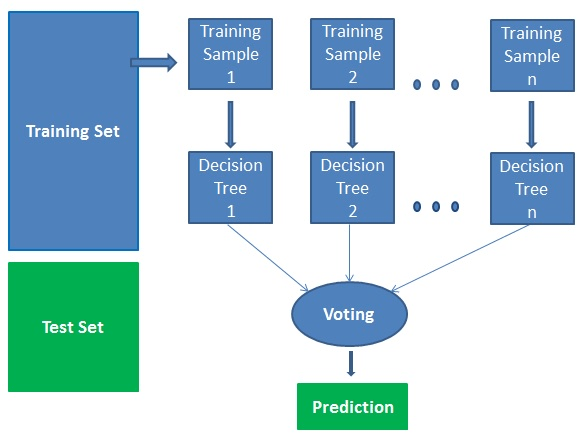

You will be building a model on the diabetes data again! No need to rexplore data as we already did that!

After splitting, you will train the model on the training set and perform predictions on the test set.

In [16]:
#Import Random Forest Function
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf=RandomForestClassifier(n_estimators=100, random_state=1)

# Train the model using the training set
rf.fit(X_train,y_train)

# Predict obs in test set
y_pred=rf.predict(X_test)

After training, check the accuracy using actual and predicted values.

In [17]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7922077922077922


You can also make a prediction for a single item, for example:

* pregnant = 0
* glucose = 115
* bp = 81
* insulin = 133
* bmi = 33
* pedigree = 0.3
* age = 31

Now you can predict which type of flower it is.
Below is the order of the variables from the split earlier in the lab

['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']

In [18]:
#Create Prediction
print(rf.predict([[0, 133, 33, 31, 115, 81, 0.3]]))

[0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Here, 0 indicates not diabetic

## Finding Important Features in Scikit-learn

Here, you are finding important features or selecting features in the Diabetes dataset. In scikit-learn, you can perform this task in the following steps:

* First, you need to create a random forests model.
* Second, use the feature importance variable to see feature importance scores.
* Third, visualize these scores using the seaborn library.

In [19]:
#Look at feature importance
feature_imp = pd.Series(rf.feature_importances_,index=feature_cols).sort_values(ascending=False)
#Display feature importance
feature_imp

glucose     0.271539
bmi         0.195373
age         0.133283
pedigree    0.131489
bp          0.092697
insulin     0.091911
pregnant    0.083709
dtype: float64

You can also visualize the feature importance. Visualizations are easy to understand and interpretable.

For visualization, you can use a combination of matplotlib and seaborn. Because seaborn is built on top of matplotlib, it offers a number of customized themes and provides additional plot types. Matplotlib is a superset of seaborn and both are equally important for good visualizations.

In [ ]:
%matplotlib inline
# Creating a bar plot

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


## Generating the Model on Selected Features

Here, you can remove the 3 features with lowest importance and select the 4 remaining features.

In [ ]:
# Split dataset into features and labels
feature_cols_2 = ['bmi', 'age','glucose','pedigree']
# Features
X = diabetes_copy[feature_cols_2]
# Target variable
y = diabetes_copy.label
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

After spliting, you will generate a model on the selected training set features, perform predictions on the selected test set features, and compare actual and predicted values.

In [ ]:
#Create a Gaussian Classifier, Creating a new name in the process
rf2=RandomForestClassifier(n_estimators=100, random_state=1)

#Train the model using the training sets
rf2.fit(X_train,y_train)

# prediction on test set
y_pred=rf2.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

You can see that after removing the least important features the accuracy didn't increase. This is because the highest importance value isn't that much higher than the lowest. A lesser amount of features also reduces the training time. So a small dip in model preformance might be worth it when dealing with large datasets!

# Adaboost classifier

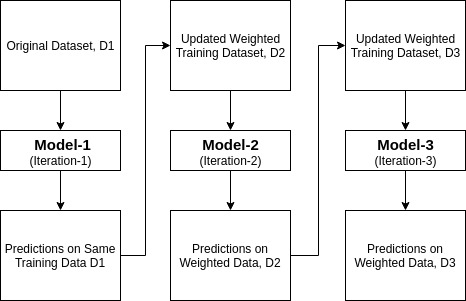

## Importing Required Library
Let's first load the required library.

In [20]:
# Load library
from sklearn.ensemble import AdaBoostClassifier

## Loading Dataset

In the model the building part, you can use the diabetes dataset from before. Since we previously removed columns we need to recreate X and Y

In [21]:
# Load data, readding the previous columns we removed
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
# Features
X = diabetes_copy[feature_cols]
# Target variable
y = diabetes_copy.label

## Split dataset

Let's split the dataset again by using function train_test_split(). you need to pass 3 parameters features, target, and test_set size.

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## Building the AdaBoost Model

Let's create the AdaBoost Model using Scikit-learn. AdaBoost uses Decision Tree Classifier as default Classifier.

In [22]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1, random_state=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

"The most important parameters are base_estimator, n_estimators, and learning_rate." (Adaboost Classifier, Chris Albon)

+ **base_estimator:** It is a weak learner used to train the model. It uses DecisionTreeClassifier as default weak learner for training purpose. You can also specify different machine learning algorithms.
+ **n_estimators:** Number of weak learners to train iteratively.
+ **learning_rate:** It contributes to the weights of weak learners. It uses 1 as a default value.

## Evaluate Model

Let's estimate, how accurately the classifier or model can predict the type of cultivars.

Accuracy can be computed by comparing actual test set values and predicted values.

In [23]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7748917748917749



For further evaluation, you can also create a model using different Base Estimators (can do a gridsearch to find best hyperparameters).

**Pros**

AdaBoost is easy to implement. It iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners. You can use many base classifiers with AdaBoost. AdaBoost is not prone to overfitting. This can be found out via experiment results, but there is no concrete reason available.

**Cons**

AdaBoost is sensitive to noise data. It is highly affected by outliers because it tries to fit each point perfectly. AdaBoost is slower compared to XGBoost.

## Using XGBoost in Python

First of all, just like what you do with any other dataset, you are going to import the California Housing dataset and store it in a variable called housing. To import it from scikit-learn you will need to run this snippet.

In [ ]:
#Import Data from sklearn
from sklearn.datasets import fetch_california_housing

#Create new dataset
housing = fetch_california_housing()

The housing variable itself is a dictionary, so you can check for its keys using the .keys() method.

In [ ]:
# Print dataset keys


You can easily check for its shape by using the data.shape attribute, which will return the size of the dataset.

In [ ]:
# Print dataset dimensions


As you can see it returned (20640, 8), that means there are 20640 rows of data with 8 columns. Now, if you want to know what the 13 columns are, you can simply use the .feature_names attribute and it will return the feature names.

In [ ]:
# Print dataset column names


The description of the dataset is available in the dataset itself. You can take a look at it using *.DESCR.*


In [ ]:
# Print dataset description


Now let’s convert it into a pandas DataFrame! For that you need to call the DataFrame() function passing the argument housing.data. To label the names of the columns, use the .columnns attribute of the pandas DataFrame

In [ ]:
# Create dataframe
cali = pd.DataFrame(#FILL IN)
#Add Columns
cali.columns = housing.feature_names

Explore the top 5 rows of the dataset by using head() method on your pandas DataFrame.

In [ ]:
# Print dataset head
cali.head()

You'll notice that there is no column called Price in the DataFrame. This is because the target column is available in another attribute called housing.target. Append the target to your pandas DataFrame.

In [ ]:
# Isolate target variable


Run the .info() method on your DataFrame to get useful information about the data.

In [ ]:
# Print info


Turns out that this dataset has 8 columns (including the target variable Price) and 20640 rows. Notice that the columns are of float data-type indicating the presence of only continuous features with no missing values in any of the columns. To get more summary statistics of the different features in the dataset you will use the describe() method on your DataFrame.

In [ ]:
# Print summary


Without delving into more exploratory analysis and feature engineering, you will now focus on applying the algorithm to train the model on this data.

You will build the model using Trees as base learners (which are the default base learners) using XGBoost's scikit-learn compatible API. Along the way, you will also learn some of the common tuning parameters which XGBoost provides in order to improve the model's performance, and using the root mean squared error (RMSE) performance metric to check the performance of the trained model on the test set. Root mean Squared error is the square root of the mean of the squared differences between the actual and the predicted values. As usual, you start by importing the library xgboost and other important libraries that you will be using for building the model.

Note you can install python libraries like xgboost on your system using pip install xgboost on cmd.

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
# Separate features and target. This time we are just seperating the last column
X, y = cali.iloc[#FILL IN],cali.iloc[#FILL IN]

Separate the target variable and rest of the variables using .iloc to subset the data.

Now you will convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. You will use this later in the tutorial.

In [ ]:
# Create Xgb DMatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

XGBoost's hyperparameters
At this point, before building the model, you should be aware of the tuning parameters that XGBoost provides. Well, there are a plethora of tuning parameters for tree-based learners in XGBoost and you can read all about them here. But the most common ones that you should know are:

* *learning_rate:* step size shrinkage used to prevent overfitting. Range is [0,1]
* *max_depth:* determines how deeply each tree is allowed to grow during any boosting round.
* *subsample:* percentage of samples used per tree. Low value can lead to underfitting.
* *colsample_bytree:* percentage of features used per tree. High value can lead to overfitting.
* *n_estimators:* number of trees you want to build.
* *objective:* determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.
XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
* *gamma:* controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
* *alpha:* L1 regularization on leaf weights. A large value leads to more regularization.
* *lambda:* L2 regularization on leaf weights and is smoother than L1 regularization.

It's also worth mentioning that though you are using trees as your base learners, you can also use XGBoost's relatively less popular linear base learners and one other tree learner known as dart. All you have to do is set the booster parameter to either gbtree (default), gblinear or dart.

Now, you will create the train and test set for cross-validation of the results using the train_test_split function from sklearn's model_selection module with test_size size equal to 20% of the data. Also, to maintain reproducibility of the results, a random_state is also assigned.

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

The next step is to instantiate an XGBoost regressor object by calling the XGBRegressor() class from the XGBoost library with the hyper-parameters passed as arguments. For classification problems, you would have used the XGBClassifier() class.

In [ ]:
# Instantiate XGB Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods.

In [ ]:
# Train model
xg_reg.fit(X_train,y_train)

# Generate predictions
preds = xg_reg.predict(X_test)

Compute the rmse by invoking the mean_sqaured_error function from sklearn's metrics module.

In [ ]:
# Compute RMSE


Well, you can see that your RMSE for the price prediction came out to be around 1.04 per 1000$.

# k-fold cross validation

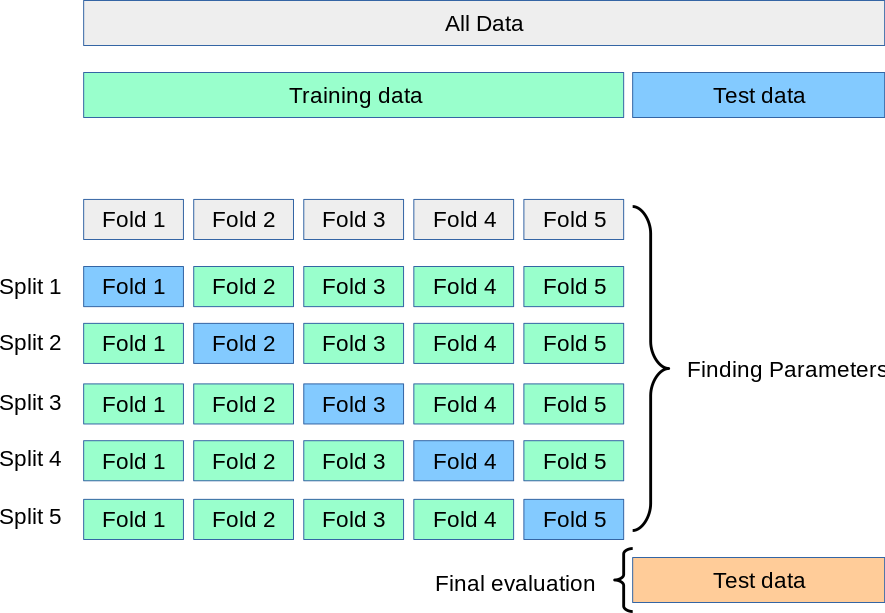


In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:

num_boost_round: denotes the number of trees you build (analogous to n_estimators)
metrics: tells the evaluation metrics to be watched during CV
as_pandas: to return the results in a pandas DataFrame.
early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
seed: for reproducibility of results.
This time you will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

You will use these parameters to build a 3-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [ ]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# Cross validation
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

cv_results contains train and test RMSE metrics for each boosting round.

In [ ]:
# Print CV results
cv_results.head()

Extract and print the final boosting round metric.

In [ ]:
# Print the boosting round metric


You can see that your RMSE for the price prediction has reduced as compared to last time and came out to be around 0.5932 per 1000$. You can reach an even lower RMSE for a different set of hyper-parameters. You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters.

## Visualize Boosting Trees and Feature Importance

You can also visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset. XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

In [ ]:
# Pass the model through a training function


Plotting the first tree with the matplotlib library:

In [ ]:
# Plot the first tree
plt.rcParams['figure.figsize'] = [50, 20]
xgb.plot_tree(xg_reg,num_trees=0) #can change num_trees
plt.show()

These plots provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions.

Note that if the above plot throws the 'graphviz' error on your system, consider installing the graphviz package via pip install graphviz on cmd. You may also need to run sudo apt-get install graphviz on cmd. (link)

Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this.

In [ ]:
# Plot the feature importance
plt.rcParams['figure.figsize'] = [5, 5]
xgb.plot_importance(xg_reg)
plt.show()

As you can see the feature MedInc has been given the highest importance score among all the features. Thus XGBoost also gives you a way to do Feature Selection.